In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx
from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import random
import math

## Network

In [3]:
nw_path = "hospital_network.txt"
g = nx.read_edgelist(nw_path, nodetype=int)
g.number_of_nodes(), g.number_of_edges()

(788, 118291)

In [4]:
print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")
print(f"Number of connected components: {nx.number_connected_components(g)}")
print(f"Transitivity: {nx.transitivity(g)}")
print(f"Average clustering coefficient: {nx.average_clustering(g)}")
print(f"Mean degree: {np.mean(list(dict(g.degree()).values()))}")

Number of nodes: 788
Number of edges: 118291
Number of connected components: 1
Transitivity: 0.5006637263008195
Average clustering coefficient: 0.49877073953557843
Mean degree: 300.2309644670051


## Flu Data

In [5]:
path = "calibration/Fludata_US_2016_2024.csv"
df_flu = pd.read_csv(path)
df_flu.drop(columns=['Unnamed: 0'], inplace=True)
df_flu.head()

,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A (H1N1)pdm09,A (H3),A (H5),A not subtyped,B (Victoria),B (Yamagata),B (lineage not determined)
0,United States of America,Non-sentinel,2016-40,2016-10-03,13380,210,13170,NaN,NaN,NaN,120,NaN,NaN,90
1,United States of America,Non-sentinel,2016-41,2016-10-10,14053,191,13862,NaN,NaN,NaN,108,NaN,NaN,83
2,United States of America,Non-sentinel,2016-42,2016-10-17,15110,212,14898,NaN,NaN,NaN,115,NaN,NaN,97
3,United States of America,Non-sentinel,2016-43,2016-10-24,15312,231,15081,NaN,NaN,NaN,143,NaN,NaN,88
4,United States of America,Non-sentinel,2016-44,2016-10-31,16652,319,16333,NaN,NaN,NaN,201,NaN,NaN,118


In [6]:
df_flu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798 entries, 0 to 797
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country area or territory            798 non-null    object 
 1   Surveillance site type               798 non-null    object 
 2   Year-week (ISO 8601 calendar)        798 non-null    object 
 3   Week start date (ISO 8601 calendar)  798 non-null    object 
 4   Specimen tested                      798 non-null    int64  
 5   Influenza positive                   798 non-null    int64  
 6   Influenza negative                   798 non-null    int64  
 7   A (H1N1)pdm09                        399 non-null    float64
 8   A (H3)                               399 non-null    float64
 9   A (H5)                               21 non-null     float64
 10  A not subtyped                       798 non-null    int64  
 11  B (Victoria)                    

In [7]:
df_flu.fillna(0, inplace=True)
type_A = [x for x in df_flu.columns if x.startswith('A')]
type_B = [x for x in df_flu.columns if x.startswith('B')]
df_flu['A'] = df_flu[type_A].sum(axis=1)
df_flu['B'] = df_flu[type_B].sum(axis=1)
df_flu.head()

,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A (H1N1)pdm09,A (H3),A (H5),A not subtyped,B (Victoria),B (Yamagata),B (lineage not determined),A,B
0,United States of America,Non-sentinel,2016-40,2016-10-03,13380,210,13170,0.0,0.0,0.0,120,0.0,0.0,90,120.0,90.0
1,United States of America,Non-sentinel,2016-41,2016-10-10,14053,191,13862,0.0,0.0,0.0,108,0.0,0.0,83,108.0,83.0
2,United States of America,Non-sentinel,2016-42,2016-10-17,15110,212,14898,0.0,0.0,0.0,115,0.0,0.0,97,115.0,97.0
3,United States of America,Non-sentinel,2016-43,2016-10-24,15312,231,15081,0.0,0.0,0.0,143,0.0,0.0,88,143.0,88.0
4,United States of America,Non-sentinel,2016-44,2016-10-31,16652,319,16333,0.0,0.0,0.0,201,0.0,0.0,118,201.0,118.0


In [8]:
df = df_flu.drop(columns=['Country area or territory', 'Surveillance site type'] + type_A + type_B)
df.head()

,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A,B
0,2016-40,2016-10-03,13380,210,13170,120.0,90.0
1,2016-41,2016-10-10,14053,191,13862,108.0,83.0
2,2016-42,2016-10-17,15110,212,14898,115.0,97.0
3,2016-43,2016-10-24,15312,231,15081,143.0,88.0
4,2016-44,2016-10-31,16652,319,16333,201.0,118.0


In [9]:
df.describe()

,Specimen tested,Influenza positive,Influenza negative,A,B
count,798.000000,798.000000,798.000000,798.000000,798.000000
mean,26569.649123,2433.373434,24136.275689,1896.890977,536.482456
std,33161.654229,5495.243346,29543.409661,4733.584697,1455.183765
min,120.000000,0.000000,110.000000,0.000000,0.000000
25%,3355.000000,84.000000,1843.500000,49.000000,13.000000
50%,13448.500000,365.500000,13147.500000,223.000000,56.500000
75%,36706.750000,1894.500000,34922.500000,1442.750000,272.000000
max,191785.000000,49007.000000,147198.000000,48835.000000,11264.000000


In [10]:
df["Year"] = df["Year-week (ISO 8601 calendar)"].apply(lambda x: int(x.split("-")[0]))
df["Week"] = df["Year-week (ISO 8601 calendar)"].apply(lambda x: int(x.split("-")[1]))
df.drop(columns=["Year-week (ISO 8601 calendar)", "Week start date (ISO 8601 calendar)"], inplace=True)
df.rename(columns={"Specimen tested": "num_sensors", "A":"I_A", "B":"I_B", "Influenza negative":"S"}, inplace=True)
df = df[["Year", "Week", "S", "I_A", "I_B","num_sensors"]]
df.head()

,Year,Week,S,I_A,I_B,num_sensors
0,2016,40,13170,120.0,90.0,13380
1,2016,41,13862,108.0,83.0,14053
2,2016,42,14898,115.0,97.0,15110
3,2016,43,15081,143.0,88.0,15312
4,2016,44,16333,201.0,118.0,16652


In [11]:
idx_to_drop = df.index[(df["num_sensors"] < 2) | (df["num_sensors"] > 788)]
df1 = df.drop(idx_to_drop).reset_index(drop=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         76 non-null     int64  
 1   Week         76 non-null     int64  
 2   S            76 non-null     int64  
 3   I_A          76 non-null     float64
 4   I_B          76 non-null     float64
 5   num_sensors  76 non-null     int64  
dtypes: float64(2), int64(4)
memory usage: 3.7 KB


In [12]:
df1.describe()

,Year,Week,S,I_A,I_B,num_sensors
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,2018.500000,28.552632,316.421053,37.157895,22.421053,376.000000
std,1.113553,5.702385,134.621669,30.933931,32.736224,163.826656
min,2017.000000,18.000000,110.000000,0.000000,0.000000,120.000000
25%,2018.000000,24.000000,227.250000,9.750000,2.000000,254.250000
50%,2018.000000,28.500000,290.500000,35.500000,11.500000,357.500000
75%,2019.250000,33.000000,385.250000,52.250000,31.250000,465.250000
max,2020.000000,39.000000,715.000000,119.000000,180.000000,788.000000


[John Micael Gran, et. al](https://pmc.ncbi.nlm.nih.gov/articles/PMC4634244/) estimate the Influenze related deaths in each season from 1998-1999 to 2010-2011. This had around 3.7 deaths per 100,000 population on average across the seasons. We use the same mortality rate for this analysis but for 2013-2014 to 2018-2019 seasons due to unavailability of data for these seasons.

In [13]:
# Deaths is a fraction of the sum of the infected
df1["D"] = [abs(x) for x in np.random.normal(loc=3.7/10**5, scale=0.1, size=len(df1))]
df1["D"] = df1[["I_A","I_B", "D"]].apply(lambda x: int((x[0]+x[1])*x[2]), axis=1)
df1.head()

/tmp/ipykernel_67633/2109423253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df1["D"] = df1[["I_A","I_B", "D"]].apply(lambda x: int((x[0]+x[1])*x[2]), axis=1)


,Year,Week,S,I_A,I_B,num_sensors,D
0,2017,20,539,69.0,180.0,788,28
1,2017,21,464,47.0,129.0,640,0
2,2017,22,382,40.0,128.0,550,6
3,2017,23,315,38.0,104.0,457,5
4,2017,24,281,52.0,65.0,398,13


In [14]:
df1["num_sensors"] = df1[["S","I_A","I_B","D"]].apply(lambda x: int(sum(x)), axis=1)
df1.head()

,Year,Week,S,I_A,I_B,num_sensors,D
0,2017,20,539,69.0,180.0,816,28
1,2017,21,464,47.0,129.0,640,0
2,2017,22,382,40.0,128.0,556,6
3,2017,23,315,38.0,104.0,462,5
4,2017,24,281,52.0,65.0,411,13


In [15]:
df1.describe()

,Year,Week,S,I_A,I_B,num_sensors,D
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,2018.500000,28.552632,316.421053,37.157895,22.421053,381.000000,5.000000
std,1.113553,5.702385,134.621669,30.933931,32.736224,166.868012,6.307667
min,2017.000000,18.000000,110.000000,0.000000,0.000000,120.000000,0.000000
25%,2018.000000,24.000000,227.250000,9.750000,2.000000,256.500000,0.000000
50%,2018.000000,28.500000,290.500000,35.500000,11.500000,362.500000,3.000000
75%,2019.250000,33.000000,385.250000,52.250000,31.250000,476.750000,6.250000
max,2020.000000,39.000000,715.000000,119.000000,180.000000,816.000000,30.000000


<Axes: >

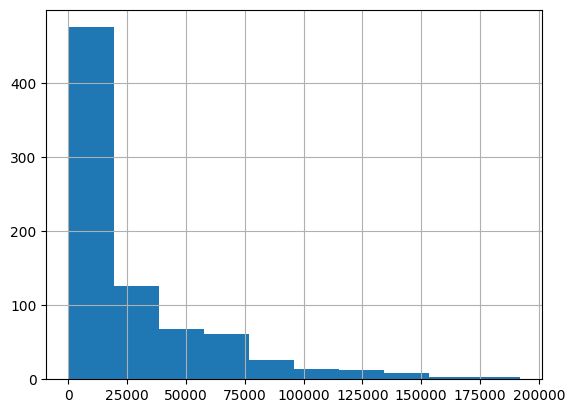

In [16]:
df["num_sensors"].hist()

In [17]:
df1["I_A"] = df1["I_A"].apply(lambda x: int(x))
df1["I_B"] = df1["I_B"].apply(lambda x: int(x))

In [18]:
for i,row in df1.iterrows():
    if row["I_A"] + row["I_B"] < row["D"]:
        print(i)

In [19]:
random.seed(1234)

In [20]:
df1 = df1[df1["num_sensors"] < 789].reset_index(drop=True)
df1.describe()

,Year,Week,S,I_A,I_B,num_sensors,D
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,2018.513514,28.540541,309.094595,35.945946,19.905405,369.513514,4.567568
std,1.113347,5.584198,128.403278,30.363051,27.262885,153.371091,5.686035
min,2017.000000,18.000000,110.000000,0.000000,0.000000,120.000000,0.000000
25%,2018.000000,24.000000,225.750000,9.250000,2.000000,249.500000,0.000000
50%,2018.000000,28.500000,286.500000,34.500000,11.000000,357.000000,3.000000
75%,2019.750000,33.000000,363.750000,51.500000,27.000000,463.500000,6.000000
max,2020.000000,39.000000,715.000000,119.000000,129.000000,745.000000,30.000000


## SISD network model

In [21]:
def choose_alive_neighbor(g, node):
    neighbors = list(g.neighbors(node))
    contact = random.choice(neighbors)
    while g.nodes[contact]['state'] == 'D':
        contact = random.choice(neighbors)
    
    return contact

In [22]:
def network_SISD(N:int, params: list[float], S0:int, I0:int, num_sensors:list[int],max_time:int, full_output:bool=False):
    """Runs SISD model on a network

    Args:
        N (int): network size
        params (list[float]): epi parameters
        S0 (int): Initial susceptible
        I0 (int): Initial infected
        num_sensors (list[int]): Number of nodes to be used as sensors at each time step
        max_time (int): Number of time steps of one simulation
        full_output (bool, optional): If true returns the state of each node at each time step. Defaults to False.

    Returns:
        list: split of the compartments among the sensors at each time step
    """
    # Get parameters
    beta_1, beta_2, gamma, delta, mu = params
    pop_size = S0 + I0
    
    # Assign states
    s_nodes = random.sample(list(g.nodes()), S0*N//pop_size)
    i_nodes = list(set(g.nodes()) - set(s_nodes))
    
    for n in s_nodes:
        g.nodes[n]['state'] = 'S'
    for n in i_nodes:
        g.nodes[n]['state'] = 'Ia'

    # Accumulate nodes in different states
    S = {0: [x for x,y in g.nodes(data=True) if y['state'] == 'S']}
    Ia = {0: [x for x,y in g.nodes(data=True) if y['state'] == 'Ia']}
    Ib = {0: [x for x,y in g.nodes(data=True) if y['state'] == 'Ib']}
    D = {0: [x for x,y in g.nodes(data=True) if y['state'] == 'D']}
    # We track only for the sensors
    states = [(0, S0/pop_size, I0/pop_size, 0.0, 0.0)]

    # Run simulation
    for t in range(max_time-1):
        s, ia, ib, d = S[t], Ia[t], Ib[t], D[t]
        # print(num_sensors[t+1], len(g.nodes()))
        sensors = random.sample(list(g.nodes()), k=num_sensors[t+1])
        for node in g.nodes():
            # Susceptible
            if g.nodes[node]['state'] == 'S':
                # Choose a random alive neighbor
                contact = choose_alive_neighbor(g, node)
                
                # S --> Ia (infected by strain A)
                if (g.nodes[contact]['state'] == 'Ia'):
                    if random.random() < beta_1:
                        g.nodes[node]['state'] = 'Ia'
                        s.remove(node)
                        ia.append(node)
                # S --> Ib (infected by strain B)
                elif (g.nodes[contact]['state'] == 'Ib'):
                    if random.random() < beta_2:
                        g.nodes[node]['state'] = 'Ib'
                        s.remove(node)
                        ib.append(node)
            
            # Strain A
            elif g.nodes[node]['state'] == 'Ia':
                # Choose a random alive neighbor
                contact = choose_alive_neighbor(g, node)
                
                # Ia --> Ib (infected by strain B)
                if (g.nodes[contact]['state'] == 'Ib'):
                    if random.random() < beta_2:
                        g.nodes[node]['state'] = 'Ib'
                        ia.remove(node)
                        ib.append(node)
                # Ia --> S (recovery)
                elif random.random() < gamma:
                    g.nodes[node]['state'] = 'S'
                    ia.remove(node)
                    s.append(node)
                # Ia --> D (death)
                elif random.random() < delta:
                    g.nodes[node]['state'] = 'D'
                    ia.remove(node)
                    d.append(node)
                # Ia --> Ib (mutation)
                elif random.random() < mu:
                    g.nodes[node]['state'] = 'Ib'
                    ia.remove(node)
                    ib.append(node)
            
            # Strain B
            elif g.nodes[node]['state'] == 'Ib':
                # Choose a random alive neighbor
                contact = choose_alive_neighbor(g, node)
                
                # Ib --> Ia (infected by strain A)
                if (g.nodes[contact]['state'] == 'Ia'):
                    if random.random() < beta_1:
                        g.nodes[node]['state'] = 'Ia'
                        ib.remove(node)
                        ia.append(node)
                # Ib --> S (recovery)
                elif random.random() < gamma:
                    g.nodes[node]['state'] = 'S'
                    ib.remove(node)
                    s.append(node)
                # Ib --> D (death)
                elif random.random() < delta:
                    g.nodes[node]['state'] = 'D'
                    ib.remove(node)
                    d.append(node)
        
        S[t+1] = list(set(s))
        Ia[t+1] = list(set(ia))
        Ib[t+1] = list(set(ib))
        D[t+1] = list(set(d))

        states.append((t+1, len(set(sensors).intersection(set(S[t+1])))/num_sensors[t+1], len(set(sensors).intersection(set(Ia[t+1])))/num_sensors[t+1],
                        len(set(sensors).intersection(set(Ib[t+1])))/num_sensors[t+1], len(set(sensors).intersection(set(D[t+1])))/num_sensors[t+1]))
        
    if full_output:
        return states, {"S":S, "Ia":Ia, "Ib":Ib, "D":D}

    return states

### Calibrating

We calibrate the `beta_1`, `beta_2`, `gamma`, `delta` and `mu` using the columns `I_A` and `I_B` in our dataset

In [23]:
# Params
beta_1 = 0.04
beta_2 = 0.1
beta_3 = 0.2
gamma = 0.05
delta = 0.0005
mu = 0.0005
S0 = df1["S"][0]
I0 = df1["I_A"][0]
max_time = len(df1)
init_params = [beta_1, beta_2, gamma, delta, mu]

In [25]:
def objective(params,S0,I0,num_sensors, max_time):
    # Run simulation
    runs = 10
    run_states = []
    for i in range(runs):
        run_states.append(network_SISD(g.number_of_nodes(), params, S0, I0, num_sensors, max_time))
    states = np.mean(run_states, axis=0)
    
    # Calculate the loss
    loss = 0
    for i in range(len(states)):
        loss += (states[i][2] - df1["I_A"].values[i])**2 + (states[i][3] - df1["I_B"].values[i])**2
        # loss += (states[i][2] - df1["I_A"].values[i])**2
    
    print("Loss:", loss)
    loss_values.append(loss)
    
    return loss

In [30]:
%%time

loss_values = []
iters = 50
opt_sol = minimize(objective, init_params, args=(S0,I0,df1["num_sensors"].values.tolist(),max_time), method='Nelder-Mead', bounds=[(0,1),(0,1),(0,1),(0,1),(0,1)],options={'maxiter':iters})
# opt_sol = minimize(objective, init_params, args=(S0,I0,df1["num_sensors"].values.tolist(),max_time),bounds=[(0,1),(0,1),(0,1),(0,1),(0,1)])
print("Done")
b1_opt, b2_opt, g_opt, d_opt, m_opt = opt_sol.x
print(f"Optimal parameters: beta_1: {b1_opt}, beta_2: {b2_opt}, gamma: {g_opt}, delta: {d_opt}, mu: {m_opt}")

Loss: 257768.70407047842
Loss: 257765.46399996887
Loss: 257793.09863865233
Loss: 257804.6705863774
Loss: 257762.82790784928
Loss: 257790.6183697549
Loss: 257669.5935037274
Loss: 257732.39849776315
Loss: 257727.98582337736
Loss: 257752.2333104423
Loss: 257729.1694865097
Loss: 257761.0704003708
Loss: 257709.66056974145
Loss: 257751.32426112177
Loss: 257749.6290863794
Loss: 257757.26813308505
Loss: 257745.40385157272
Loss: 257749.5159643302
Loss: 257742.63089670235
Loss: 257758.5890551578
Loss: 257731.52001608582
Loss: 257721.74554691077
Loss: 257729.02154153967
Loss: 257740.3071264331
Loss: 257742.00277673957
Loss: 257727.6554301941
Loss: 257716.0155660598
Loss: 257730.66236557654
Loss: 257758.9479733613
Loss: 257718.6055578899
Loss: 257758.6788509974
Loss: 257744.97366219372
Loss: 257717.70753838186
Loss: 257729.54381781243
Loss: 257746.20757858467
Loss: 257750.9391995322
Loss: 257754.57764869605
Loss: 257747.55131557354
Loss: 257720.40119238806
Loss: 257721.78385877007
Loss: 257751.473

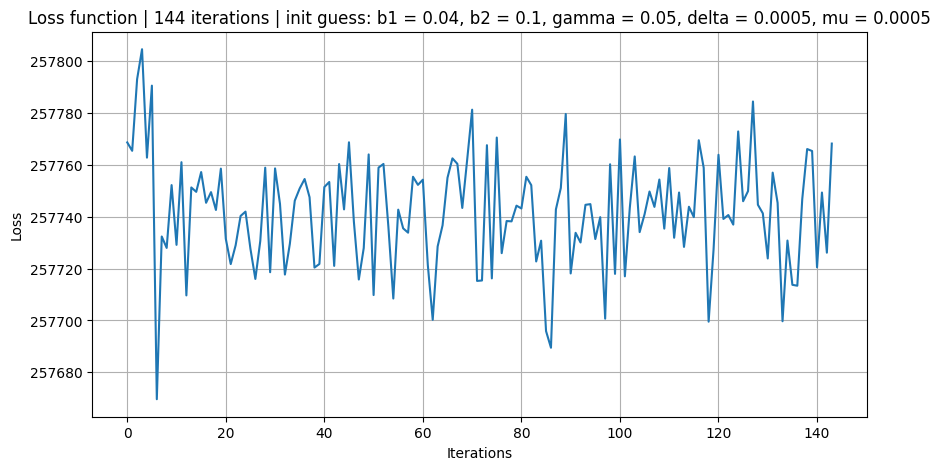

In [31]:
plt.figure(figsize=(10,5))
plt.plot(loss_values)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Loss function | {len(loss_values)} iterations | init guess: b1 = {beta_1}, b2 = {beta_2}, gamma = {gamma}, delta = {delta}, mu = {mu}")
plt.grid()
plt.savefig(f"loss_function_{len(loss_values)}_iters.png")
plt.show()

In [35]:
def sisd_ode(t, init, params):
    # Initital fractions
    S, I1, I2, D = init
    # Parameters
    beta1, beta2, gamma, delta, mu = params

    # one_two = mu*(random.random() <= mu)
    one_two = mu
    # two_three = mu*(random.random() <= mu)
    two_three = mu


    # ODEs
    dS = -S*(beta1*I1 + beta2*I2) + gamma*(I1 + I2)
    dI1 = S*beta1*I1 - gamma*I1 - delta*I1 - I1*one_two - beta2*I1*I2
    dI2 = S*beta2*I2 - gamma*I2 - delta*I2 - two_three*I2 + one_two*I1 + beta2*I1*I2
    dD = delta*(I1 + I2)

    return [dS, dI1, dI2, dD]

In [39]:
from scipy.integrate import odeint

times = range(max_time)
def ode_obj(t, init, params):
    # Solve ODE
    sol = solve_ivp(fun=lambda t, y: sisd_ode(t, y, params), t_span=[min(times),max(times)], y0=init, t_eval=times, method="RK45")
    # Calculate loss
    loss = 0
    for i in range(len(sol["y"])):
        loss += (sol["y"][1][i] - df1["I_A"][i])**2 + (sol["y"][2][i] - df1["I_B"][i])**2
    loss_values.append(loss)
    return loss

In [40]:
%%time

loss_values = []
iters = 50
opt_sol = minimize(ode_obj, init_params, args=([S0,I0,0,0],init_params), method='Nelder-Mead', bounds=[(0,1),(0,1),(0,1),(0,1),(0,1)],options={'maxiter':iters})
# opt_sol = minimize(objective, init_params, args=(S0,I0,df1["num_sensors"].values.tolist(),max_time),bounds=[(0,1),(0,1),(0,1),(0,1),(0,1)])
print("Done")
b1_opt, b2_opt, g_opt, d_opt, m_opt = opt_sol.x
print(f"Optimal parameters: beta_1: {b1_opt}, beta_2: {b2_opt}, gamma: {g_opt}, delta: {d_opt}, mu: {m_opt}")

Done
Optimal parameters: beta_1: 0.04, beta_2: 0.1, gamma: 0.05, delta: 0.0005, mu: 0.0005
CPU times: user 2.75 s, sys: 8.52 ms, total: 2.76 s
Wall time: 2.75 s


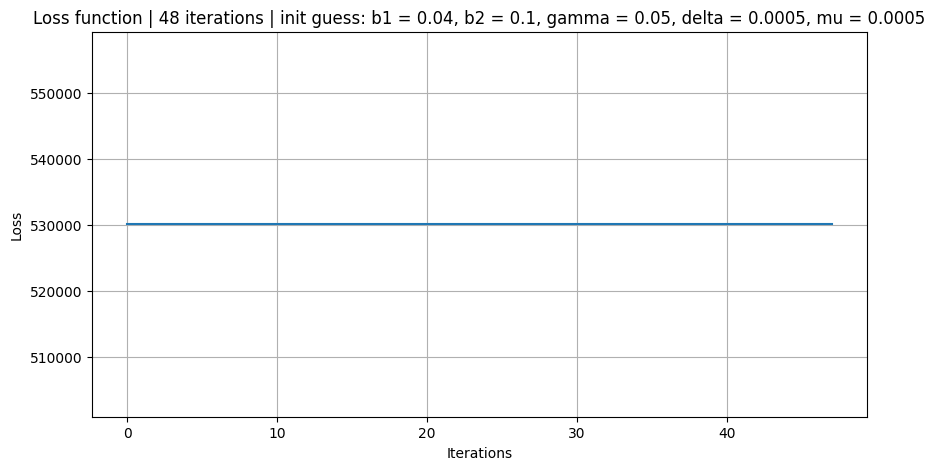

In [41]:
plt.figure(figsize=(10,5))
plt.plot(loss_values)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title(f"Loss function | {len(loss_values)} iterations | init guess: b1 = {beta_1}, b2 = {beta_2}, gamma = {gamma}, delta = {delta}, mu = {mu}")
plt.grid()
plt.savefig(f"loss_function_{len(loss_values)}_iters.png")
plt.show()